In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
import os

In [2]:
#just for cleaningness purpuses in the final report
import warnings
warnings.filterwarnings("ignore")

#defining working path
path = 'C:/Users/User/Desktop/Data Science/FCD/individual assay/SSD-generator/chemicals'
os.chdir(path)

In [3]:
def preprocess (initial_data):
    
    data = initial_data.copy()
    
    #remove trailing spaces from columns names
    data.columns = pd.Series(data.columns).str.strip().tolist()
        
    #saving cas
    cas = data.loc[0,'CAS Number']
    chem_name = data.loc[0,'Chemical Name']
    
    #parameter restriction
    type_chem = data['Conc 1 Type (Standardized)'].mode()[0]
    data = data[data['Conc 1 Type (Standardized)'] == type_chem]
    
    data = data[data['Conc 1 Mean (Standardized)'] != 'NR']
    
    unit = data['Conc 1 Units (Standardized)'].mode()[0]                 
    data = data[data['Conc 1 Units (Standardized)'] == unit]
    
    data = data[data['Conc 1 Mean Op (Standardized)'].isna()]

    if 'Observed Duration Mean (Days)' in data.columns:
        days = data['Observed Duration Mean (Days)'].mode()[0]
        data = data[data['Observed Duration Mean (Days)'] == days]
    elif 'Observed Duration (Days)' in data.columns:
        days = data['Observed Duration (Days)'].mode()[0]
        data = data[data['Observed Duration (Days)'] == days]
    
    #new df
    cols = ['Species Scientific Name','Conc 1 Mean (Standardized)','Conc 1 Units (Standardized)',
            'Species Group', 'CAS Number', 'Chemical Name'] #'Observed Duration Mean (Days)'
    data = data[cols]
    
    #toxicity str to float
    data = data[['Species Scientific Name','Conc 1 Mean (Standardized)']]
    data.loc[:,'Conc 1 Mean (Standardized)'] = data.loc[:,'Conc 1 Mean (Standardized)'].astype(float)
    
    data = data.groupby('Species Scientific Name', as_index=False)['Conc 1 Mean (Standardized)'].median()
    data = data.sort_values(by=['Conc 1 Mean (Standardized)'])
    data.reset_index(drop=True,inplace=True)
    data['Units'] = unit
    data['CAS'] = cas
    data['Chemical Name'] = chem_name
    
    return data

In [4]:
def plot_SSD (data):
    #finding order of magnitude of min and of max(+1)
    low = data.iloc[:,1].min()
    high = data.iloc[:,1].max()

    xmin, xmax = math.floor(math.log(low, 10))-1, (math.floor(math.log(high, 10)))+2

    plt.figure(figsize=(6,4.5))
    #plotting data points
    a = data.iloc[:,1]

    n_species = data.shape[0]
    perc_val = np.arange(n_species)+1
    percent = [(x-0.5)/data.shape[0] for x in perc_val]

    plt.scatter(a, percent,color='black')


    #plotting fitted lognormal function
    s, loc, scale = stats.lognorm.fit(a)

    x = np.logspace(xmin, xmax, 100)
    y = [stats.lognorm.cdf(x, s, loc=0, scale=scale) for x in x]
    plt.plot(x,y,color='red')

    #adjusting x-axis
    plt.xscale("log")
    plt.gca().set_xlim([math.pow(10,xmin), math.pow(10, xmax)])
    plt.title('SSD for '+ str(data.loc[0,'CAS']))
    plt.ylabel('Fraction Affected')
    plt.xlabel('log10 toxicity data')
    plt.subplot().spines['right'].set_visible(False)
    plt.subplot().spines['top'].set_visible(False)
    
    return plt.show()

In [5]:
def get_HC_AD (data):
    #data points
    a = data.iloc[:,1]

    n_species = data.shape[0]
    perc_val = np.arange(n_species)+1
    percent = [(x-0.5)/data.shape[0] for x in perc_val]

    #fitted lognormal function
    s, loc, scale = stats.lognorm.fit(a)
    
    #HC and AD
    hc5 = stats.lognorm.ppf(0.05, s, loc=0, scale=scale)
    hc50 = scale
    
    adt = stats.anderson(a,dist='logistic')
    if adt[1][2] < 0.752:
        return hc5, hc50, adt[1][2]
    else:
        return 'Error', 'Error', 'Error'

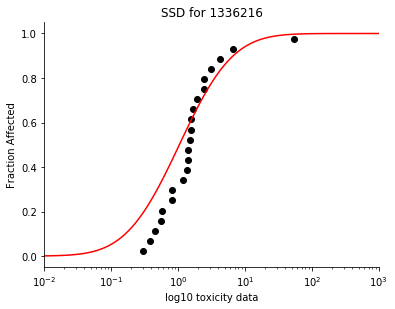

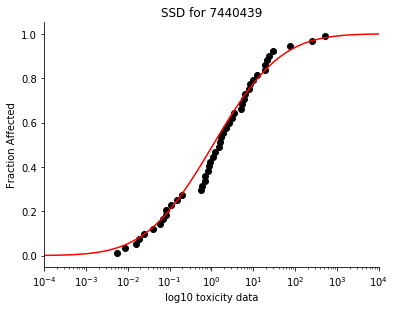

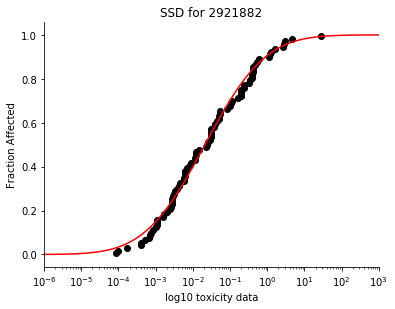

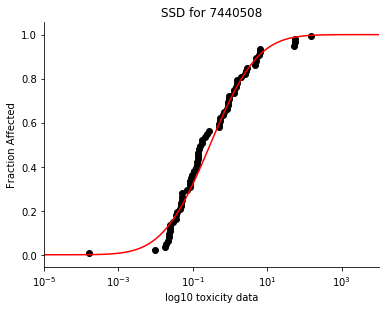

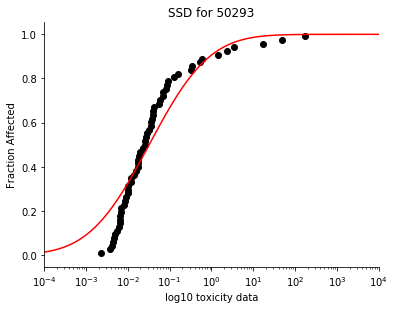

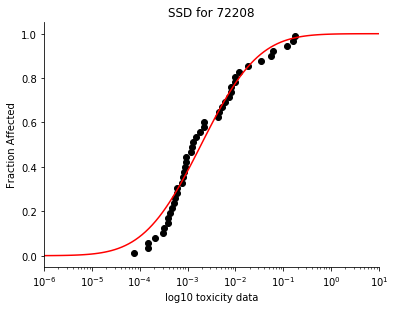

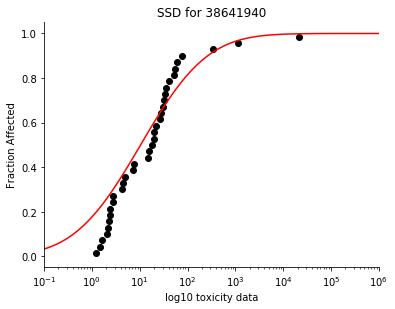

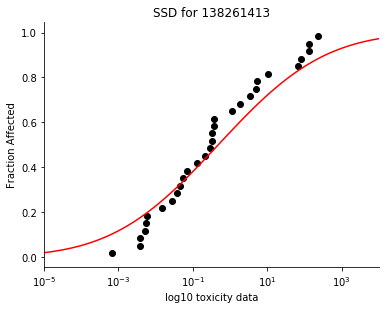

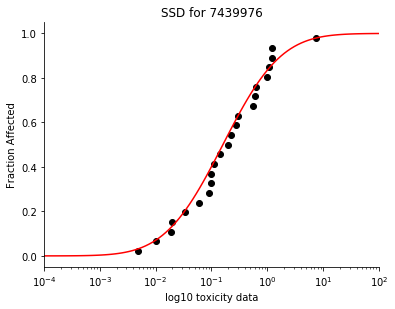

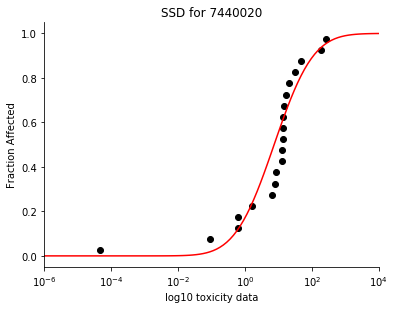

In [6]:
ecotox_data = pd.DataFrame(columns=['Chemical','CAS','HC5','HC50','Units','AD(p=0.05)'])

#Pipeline
for f in os.listdir():
    new_path = path + '/' + str(f)
    chems = pd.read_csv(new_path,  sep='|')

    proc_chems = preprocess (chems)
    plot_SSD (proc_chems)
    hc5, hc50, adf = get_HC_AD(proc_chems)
    
    chem_name = f[0:-4]                            
    cas = str(proc_chems.loc[0,'CAS'])
    units = proc_chems.loc[0,'Units']
    
    ecotox_data.loc[len(ecotox_data)] = [chem_name, cas, hc5, hc50, units, adf]

In [7]:
#displaying dataframe
ecotox_data

,Chemical,CAS,HC5,HC50,Units,AD(p=0.05)
0,Ammonia,1336216,0.097141,1.047295,AI mg/L,0.653
1,Cadmium,7440439,0.009026,1.097957,AI mg/L,0.656
2,Chlorpyrifos,2921882,0.000169,0.021072,AI mg/L,0.658
3,Copper,7440508,0.006562,0.291038,AI mg/L,0.658
4,DDT,50293,0.000450,0.032500,AI mg/L,0.657
5,Endrin,72208,0.000055,0.001922,AI mg/L,0.656
6,Glyphosate,38641940,0.164476,10.418772,AI mg/L,0.655
7,Imidacloprid,138261413,0.000097,0.484036,AI mg/L,0.655
8,Mercury,7439976,0.007232,0.160197,AI mg/L,0.653
9,Nickel,7440020,0.230832,7.435401,AI mg/L,0.652
